# Reproduce systematic generalization

In [2]:
%matplotlib inline

import io
import os
import json
import torch
import h5py
import numpy as np
import PIL
import matplotlib.pyplot as plt
from torch import nn
from os.path import join
from torch.utils.tensorboard import SummaryWriter, FileWriter
from torch.autograd import Variable

In [3]:
import sys
sys.path.append("..")

from vr.utils import load_execution_engine, load_program_generator
from train_model import get_execution_engine
from vr.utils import load_vocab
from vr.data import ClevrDataset, ClevrDataLoader
from train_model import check_accuracy

In [6]:
def generate_bash_list(lst_id):
    str_bash = ''
    for slurm_id in lst_id:
        str_bash += '"%s.pt.best" ' % slurm_id
    return str_bash

In [7]:
# useful when we turn the args dictionary into an object (e.g., check_accuracy)

class Dict2Obj(object):
    """
    Turns a dictionary into a class
    """
    def __init__(self, dictionary):
        for key in dictionary:
            setattr(self, key, dictionary[key])

In [109]:
def retrieve_learning_performance(slurm_id_list, path_model):
    """ We assume that the list contains experiments which are equivalent 
    in their keys 
    slurm_id_list: list, slurm id referred to experiments with identical hyperparameters
    path_model: str, root path to the files 
    """
    
    for i_, slurm_id in enumerate(slurm_id_list):
        
        model_json = json.load(open(join(path_model, slurm_id+'.pt.json'), 'rb'))
        n_iters = model_json['args']['num_iterations']
        step_width_others = model_json['args']['checkpoint_every']
        step_width_tr_loss = model_json['args']['record_loss_every']
        
        if i_ == 0:
            array_tr_loss = np.nan * np.ones((len(slurm_id_list), n_iters // step_width_tr_loss))
            array_tr_accs = np.nan * np.ones((len(slurm_id_list), n_iters // step_width_others))
            array_vl_accs = np.nan * np.ones((len(slurm_id_list), n_iters // step_width_others))
        
        array_tr_loss[i_,:np.array(model_json['train_losses']).size] = np.array(model_json['train_losses'])   
        array_tr_accs[i_,:np.array(model_json['train_accs']).size] = np.array(model_json['train_accs'])
        array_vl_accs[i_,:np.array(model_json['val_accs']).size] = np.array(model_json['val_accs'])

    iters_array_tr_loss = np.arange(0, n_iters, step_width_tr_loss)
    iters_array_others = np.arange(0, n_iters, step_width_others)
    
    return iters_array_tr_loss, array_tr_loss, iters_array_others, array_tr_accs, array_vl_accs

In [16]:
def retrieve_id_repeated_experiments(slurm_id=None, path_model='.', args=None):
    """ We can pass the slurm_id, or alternatively the dictionary defining the experiments.
    ----------------
    Parameters 
        slurm_id: str, slurm id from which we extract the hyperparameters
        path_model: str, root path to the files
        args: dict, containing the keys for the experiment
    ----------------
    Returns
        lst_equal_files: list, list of slurm id
    """
    
    json_files = [f_ for f_ in os.listdir(path_model) if f_.endswith('.json')]
    lst_equal_files = []
    
    if args is None:
        model_json = json.load(open(join(path_model, slurm_id+'.pt.json'), 'rb'))
        
        dct = model_json['args']
        del dct['checkpoint_path']

        for json_f in json_files:  # list of candidate slurmids.pt.json
            try:
                loaded_file = json.load(open(join(path_model, json_f), 'rb'))
                equal = True
                dct_comparison = loaded_file['args']
                del dct_comparison['checkpoint_path']
        
                if len(dct_comparison) == len(dct):
                    for (k_, i_) in dct.items():
                        if i_ != dct_comparison[k_]:
                            equal = False
                            break  # we pass to the new json
                    if equal:
                        lst_equal_files.append(json_f)
                else:
                    continue

            except:
                continue
        return [f_.split('.')[0] for f_ in lst_equal_files]
    
    else:
        lst_equal_files = []
        for json_f in json_files:  # list of candidate slurmids.pt.json
            try:
                loaded_args = json.load(open(join(path_model, json_f), 'rb'))['args']
                equal = True
                for (key_, item_) in args.items():
                    if loaded_args[key_] != item_:
                        equal = False
                        break
                if equal:
                    lst_equal_files.append(json_f)
            except:
                continue
        
        return lst_equal_files

In [9]:
def read_output_files(slurm_id_lst, 
                      path_output):
    """
    ----------------
    Parameters 
        slurm_id_lst: str, slurm id from which we extract the hyperparameters
        path_model: str, root path to the files
    ----------------
    Returns
        test error: np.array of test error
    """
    output_list_files = [join(path_output, 'output_%s.pt.b.h5' % slurm_id) for slurm_id in slurm_id_lst]

    test_accuracy = []

    for output_file in output_list_files:
        output = h5py.File(output_file, 'r') 
        correct = np.array(list(output['correct']))  

        test_accuracy.append(np.sum(correct).astype('float') / correct.size)
        probs = np.array(list(output['probs']))
        scores = np.array(list(output['scores']))

    test_accuracy = np.array(test_accuracy)
    return 1 - test_accuracy

# Retrieve results experiments in Sys Gen

In [54]:
root_path_data_dir = '/om/user/vanessad/om/user/vanessad/compositionality'

num_iterations = {'FiLM': 200000,
                  'MAC': 100000,
                  'ConvLSTM': 200000,
                  'RelNet': 500000,
                  'NMNRes': 50000,
                  'NMNFind': 200000,
                  'StochNMNFind': 200000,
                  'StochNMNRes': 200000,
                  'AttNMNFind': 50000
                  }

common_batch_size = 64
batch_size = {'FiLM': common_batch_size,
              'MAC': 2*common_batch_size,
              'ConvLSTM': 2*common_batch_size,
              'RelNet': common_batch_size,
              'NMNRes': common_batch_size,
              'NMNFind': common_batch_size,
              'StochNMNFind': common_batch_size,
              'StochNMNRes': common_batch_size,
              'AttNMNFind': common_batch_size
             }

dataset_configurations = {1: 'sqoop-variety_1-repeats_30000',
                          2: 'sqoop-variety_2-repeats_15000',
                          4: 'sqoop-variety_4-repeats_7500',
                          8: 'sqoop-variety_8-repeats_3750',
                          18: 'sqoop-variety_18-repeats_2000',
                          35: 'sqoop-variety_35-repeats_1000_vanilla'}

# where we saved the *.pt, *.pt.best, and the *.pt.json
path_model = '/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train'

# FiLM model

In [94]:
method = 'FiLM'
lhs = 1

dct = {'batch_size': batch_size[method],
       'checkpoint_every': 1000,
       'data_dir': join(root_path_data_dir, dataset_configurations[lhs]),
       'model_type': method,
       'num_iterations': num_iterations[method],
      }

lst_json = retrieve_id_repeated_experiments(slurm_id=None, path_model=path_model, args=dct)
first_exp_slurm_id = lst_json[0].split('.')[0]
first_exp_slurm_id
lst_slurm_id_film_1 = retrieve_id_repeated_experiments(first_exp_slurm_id, path_model=path_model)
print(lst_slurm_id_film_1)
test_film_1 = read_output_files(lst_slurm_id_film_1, path_output=path_model)

['17337052', '17337048', '17337050', '17337051', '17337049']


In [95]:
lhs = 4
dct['data_dir'] = join(root_path_data_dir, dataset_configurations[lhs])

lst_json = retrieve_id_repeated_experiments(slurm_id=None, path_model=path_model, args=dct)
lst_slurm_id_film_4 = retrieve_id_repeated_experiments(lst_json[0].split('.')[0], path_model=path_model)
print(lst_slurm_id_film_4)
test_film_4 = read_output_files(lst_slurm_id_film_4, path_output=path_model)

['17318735', '17318740', '17318729', '17318738', '17318736', '17318742', '17318741', '17318739']


In [96]:
lhs = 18
dct['data_dir'] = join(root_path_data_dir, dataset_configurations[lhs])

lst_json = retrieve_id_repeated_experiments(slurm_id=None, path_model=path_model, args=dct)
lst_slurm_id_film_18 = retrieve_id_repeated_experiments(lst_json[0].split('.')[0], path_model=path_model)
print(lst_slurm_id_film_18)
test_film_18 = read_output_files(lst_slurm_id_film_18, path_output=path_model)

['17327839', '17327938', '17327936', '17327939', '17327793', '17327935', '17327874', '17327937', '17327940']


Text(0.5, 1.0, 'FiLM')

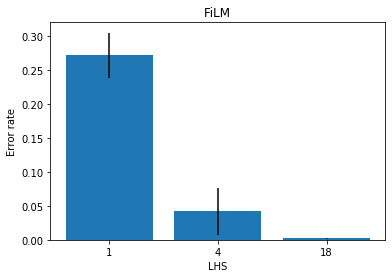

In [97]:
film_exps = [test_film_1, test_film_4, test_film_18]

fig, ax = plt.subplots()
ax.bar(np.arange(len(film_exps)), [np.mean(ts_) for ts_ in film_exps], 
        yerr=[np.std(ts_) for ts_ in film_exps])
ax.set_xticks(np.arange(len(film_exps)))
ax.set_xticklabels([1, 4, 18])
plt.xlabel('LHS')
plt.ylabel('Error rate')
plt.title('FiLM')

# MAC model 

In [392]:
method = 'MAC'
lhs = 1

dct = {'batch_size': batch_size[method],
       'checkpoint_every': 1000,
       'data_dir': join(root_path_data_dir, dataset_configurations[lhs]),
       'model_type': method,
       'num_iterations': num_iterations[method],
      }

lst_json = retrieve_id_repeated_experiments(slurm_id=None, path_model=path_model, args=dct)
lst_slurm_id_mac_1 = retrieve_id_repeated_experiments(lst_json[0].split('.')[0], path_model=path_model)
print(lst_slurm_id_mac_1)
test_mac_1 = read_output_files(lst_slurm_id_mac_1, path_output=path_model)

['17329167', '17329163', '17329166', '17329168', '17329164', '17329165']


In [99]:
lhs = 4
dct['data_dir'] = join(root_path_data_dir, dataset_configurations[lhs])

lst_json = retrieve_id_repeated_experiments(slurm_id=None, path_model=path_model, args=dct)
lst_slurm_id_mac_4 = retrieve_id_repeated_experiments(lst_json[0].split('.')[0], path_model=path_model)
print(lst_slurm_id_mac_4)
test_mac_4 = read_output_files(lst_slurm_id_mac_4, path_output=path_model)

['17333626', '17333627', '17333624', '17333625', '17333628', '17333623']


In [393]:
lhs = 8
dct['data_dir'] = join(root_path_data_dir, dataset_configurations[lhs])

lst_json = retrieve_id_repeated_experiments(slurm_id=None, path_model=path_model, args=dct)
lst_slurm_id_mac_8 = retrieve_id_repeated_experiments(lst_json[0].split('.')[0], path_model=path_model)
print(lst_slurm_id_mac_8)

# here one of the 8 is missing
# test_mac_8 = read_output_files(lst_slurm_id_mac_8, path_output=path_model)

['17336922', '17336918', '17336920', '17336917', '17336919']


In [394]:
path_ = '/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train'
output_list_files = [join(path_, '%s.pt.json' % slurm_id) for slurm_id in lst_slurm_id_mac_8]

for json_ in output_list_files:
    
    model_json = json.load(open(json_, 'rb'))
    num_iters = model_json['args']['num_iterations']
    num_saved_loss_vals = len(model_json['train_losses'])
    record_every = model_json['args']['record_loss_every']
    if num_iters == record_every * num_saved_loss_vals:
        print('same') 
    else:
        print('stopped')
        print(json_)   
        print(num_saved_loss_vals * record_every)
    print('..........................................................')

same
..........................................................
same
..........................................................
same
..........................................................
stopped
/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train/17336917.pt.json
93000
..........................................................
same
..........................................................


In [395]:
generate_bash_list(lst_slurm_id_mac_8)

'"17336922.pt.best" "17336918.pt.best" "17336920.pt.best" "17336917.pt.best" "17336919.pt.best" '

Text(0.5, 1.0, 'MAC')

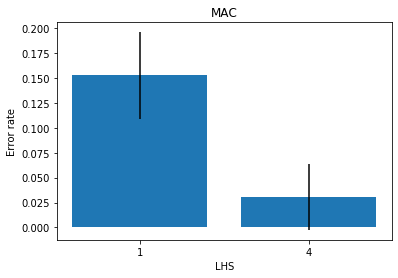

In [102]:
mac_exps = [test_mac_1, test_mac_4]

fig, ax = plt.subplots()
ax.bar(np.arange(len(mac_exps)), [np.mean(ts_) for ts_ in mac_exps], 
        yerr=[np.std(ts_) for ts_ in mac_exps])
ax.set_xticks(np.arange(len(mac_exps)))
ax.set_xticklabels([1, 4])
plt.xlabel('LHS')
plt.ylabel('Error rate')
plt.title('MAC')

# NMN chain

In [104]:
lhs = 1

dct = {'batch_size': batch_size['NMNRes'],
       'checkpoint_every': 1000,
       'data_dir': join(root_path_data_dir, dataset_configurations[lhs]),
       'model_type': 'SHNMN',
       'tau_init': 'chain',
       'num_iterations': num_iterations['NMNRes'],
       'stem_dim': 64,
      }

lst_json = retrieve_id_repeated_experiments(slurm_id=None, path_model=path_model, args=dct)
lst_slurm_id_chain_1 = retrieve_id_repeated_experiments(lst_json[0].split('.')[0], path_model=path_model)
print(lst_slurm_id_chain_1)
nmn_chain_1 = read_output_files(lst_slurm_id_chain_1, path_output=path_model)

['17335027', '17335023', '17335025', '17335026', '17335024']


# NMN tree

In [105]:
lhs = 1

dct = {'batch_size': batch_size['NMNRes'],
       'checkpoint_every': 1000,
       'data_dir': join(root_path_data_dir, dataset_configurations[lhs]),
       'model_type': 'SHNMN',
       'tau_init': 'tree',
       'num_iterations': num_iterations['NMNRes'],
       'stem_dim': 64,
      }

lst_json = retrieve_id_repeated_experiments(slurm_id=None, path_model=path_model, args=dct)
lst_slurm_id_tree = retrieve_id_repeated_experiments(lst_json[0].split('.')[0], path_model=path_model)
print(lst_slurm_id_tree)
nmn_tree_1 = read_output_files(lst_slurm_id_tree, path_output=path_model)

['17334841', '17334848', '17334849', '17334842', '17334847']


# Attention NMN

In [398]:
lhs = 1

dct = {'batch_size': batch_size['AttNMNFind'],
       'checkpoint_every': 1000,
       'data_dir': join(root_path_data_dir, dataset_configurations[lhs]),
       'model_type': 'SHNMN',
       'num_iterations': num_iterations['AttNMNFind'],
       'stem_dim': 64,
      }

lst_json = retrieve_id_repeated_experiments(slurm_id=None, path_model=path_model, args=dct)
lst_slurm_id_attention = retrieve_id_repeated_experiments(lst_json[0].split('.')[0], path_model=path_model)
print(lst_slurm_id_attention)
nmn_attention_1 = read_output_files(lst_slurm_id_attention, path_output=path_model)

['17335027', '17335023', '17335025', '17335026', '17335024']


Text(0.5, 1.0, 'NMN')

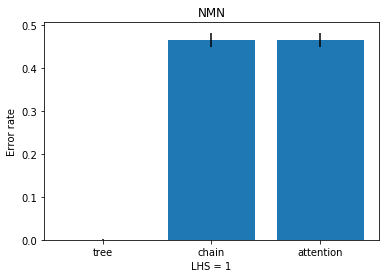

In [399]:
nmn_exps = [nmn_tree_1, nmn_chain_1, nmn_attention_1]

fig, ax = plt.subplots()
ax.bar(np.arange(len(nmn_exps)), [np.mean(ts_) for ts_ in nmn_exps], 
        yerr=[np.std(ts_) for ts_ in nmn_exps])
ax.set_xticks(np.arange(len(nmn_exps)))
ax.set_xticklabels(['tree', 'chain', 'attention'])
plt.xlabel('LHS = 1')
plt.ylabel('Error rate')
plt.title('NMN')

# Convergence time for FiLM

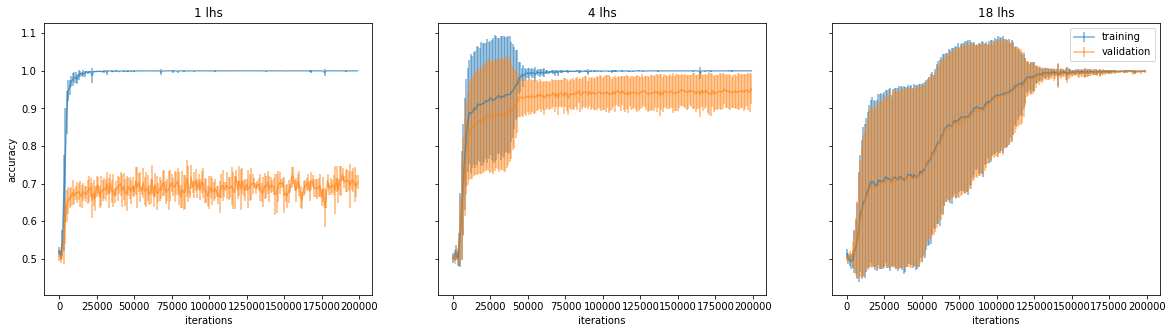

In [133]:
fig, ax = plt.subplots(figsize=(20,5), ncols=3, sharey=True)

lhs_list = [1,4,18]

for id_, lst_slurm_id in enumerate([lst_slurm_id_film_1, lst_slurm_id_film_4, lst_slurm_id_film_18]):

    x_tr_ls, tr_ls, x, acc_tr, acc_vl = retrieve_learning_performance(lst_slurm_id, path_model)
    ax[id_].errorbar(x, np.mean(acc_tr, axis=0), np.std(acc_tr, axis=0), alpha=0.6, label='training')
    ax[id_].errorbar(x, np.mean(acc_vl, axis=0), np.std(acc_vl, axis=0), alpha=0.6, label='validation')
    ax[id_].set_title('%i lhs' %lhs_list[id_])
    ax[id_].set_xlabel('iterations', fontsize=10)
    
ax[0].set_ylabel('accuracy', fontsize=10);
plt.legend()

# Convergence time for MAC

No handles with labels found to put in legend.


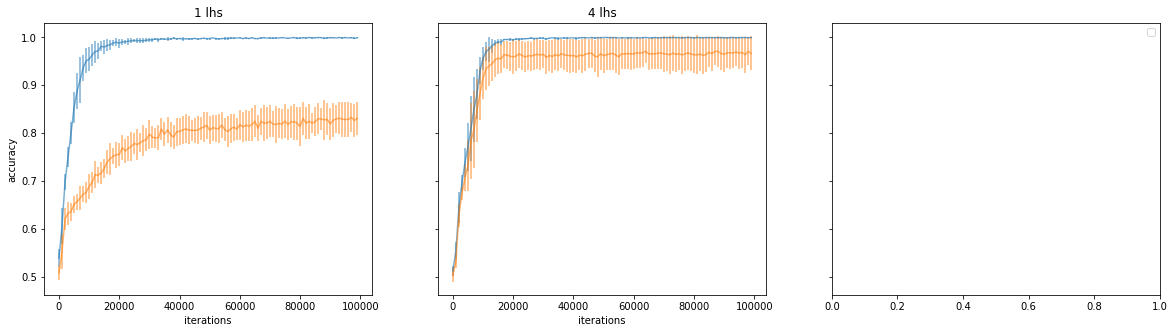

In [134]:
fig, ax = plt.subplots(figsize=(20,5), ncols=3, sharey=True)

lhs_list = [1,4]

for id_, lst_slurm_id in enumerate([lst_slurm_id_mac_1, lst_slurm_id_mac_4]):

    x_tr_ls, tr_ls, x, acc_tr, acc_vl = retrieve_learning_performance(lst_slurm_id, path_model)
    ax[id_].errorbar(x, np.mean(acc_tr, axis=0), np.std(acc_tr, axis=0), alpha=0.6, label='training')
    ax[id_].errorbar(x, np.mean(acc_vl, axis=0), np.std(acc_vl, axis=0), alpha=0.6, label='validation')
    ax[id_].set_title('%i lhs' %lhs_list[id_])
    ax[id_].set_xlabel('iterations', fontsize=10)
    
ax[0].set_ylabel('accuracy', fontsize=10);
plt.legend()

# Convergence time for NMN (chain and tree)

In [138]:
lst_slurm_id_chain_1, lst_slurm_id_tree

(['17335027', '17335023', '17335025', '17335026', '17335024'],
 ['17334841', '17334848', '17334849', '17334842', '17334847'])

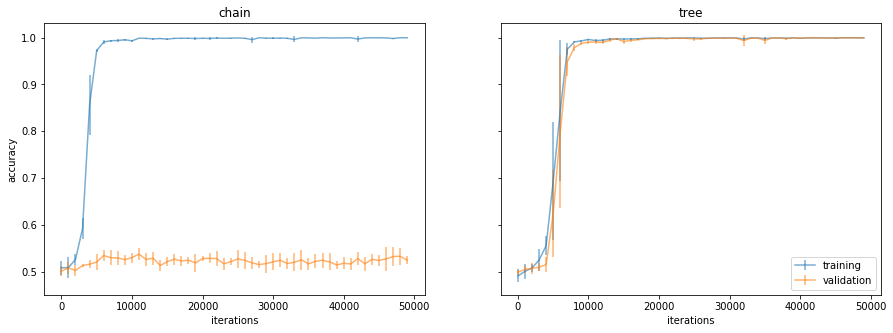

In [139]:
fig, ax = plt.subplots(figsize=(15,5), ncols=2, sharey=True)
title_list = ['chain', 'tree']

for id_, lst_slurm_id in enumerate([lst_slurm_id_chain_1, lst_slurm_id_tree]):

    x_tr_ls, tr_ls, x, acc_tr, acc_vl = retrieve_learning_performance(lst_slurm_id, path_model)
    ax[id_].errorbar(x, np.mean(acc_tr, axis=0), np.std(acc_tr, axis=0), alpha=0.6, label='training')
    ax[id_].errorbar(x, np.mean(acc_vl, axis=0), np.std(acc_vl, axis=0), alpha=0.6, label='validation')
    ax[id_].set_title(title_list[id_])
    ax[id_].set_xlabel('iterations', fontsize=10)
    
ax[0].set_ylabel('accuracy', fontsize=10);
plt.legend()

# RelNet

In [152]:
lhs = 1

dct = {'batch_size': batch_size['RelNet'],
       'checkpoint_every': 1000,
       'data_dir': join(root_path_data_dir, dataset_configurations[lhs]),
       'model_type': 'RelNet',
       'num_iterations': num_iterations['RelNet'],
      }

lst_json = retrieve_id_repeated_experiments(slurm_id=None, path_model=path_model, args=dct)
lst_slurm_id_ = retrieve_id_repeated_experiments(lst_json[0].split('.')[0], path_model=path_model)

output_list_files = [join(path_, '%s.pt.json' % slurm_id) for slurm_id in lst_slurm_id_]

for json_ in output_list_files:
    
    model_json = json.load(open(json_, 'rb'))
    num_iters = model_json['args']['num_iterations']
    num_saved_loss_vals = len(model_json['train_losses'])
    record_every = model_json['args']['record_loss_every']
    if num_iters == record_every * num_saved_loss_vals:
        print('same') 
    else:
        print('stopped')
        print(json_)   
        print(num_saved_loss_vals * record_every)
    print('..........................................................')

stopped
/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train/17336895.pt.json
75000
..........................................................
stopped
/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train/17336893.pt.json
115000
..........................................................
stopped
/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train/17336904.pt.json
70000
..........................................................
stopped
/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train/17336902.pt.json
73000
..........................................................
stopped
/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train/17336892.pt.json
113000
..........................................................
stopped
/om/user/vanessad/om/user/vanessad/original_librar

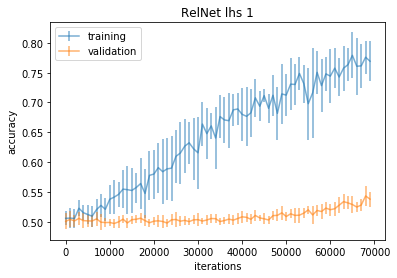

In [153]:
x_tr_ls, tr_ls, x, acc_tr, acc_vl = retrieve_learning_performance(lst_slurm_id_, path_model)
plt.errorbar(x, np.mean(acc_tr, axis=0), np.std(acc_tr, axis=0), alpha=0.6, label='training')
plt.errorbar(x, np.mean(acc_vl, axis=0), np.std(acc_vl, axis=0), alpha=0.6, label='validation')
plt.title('RelNet lhs 1')
plt.xlabel('iterations', fontsize=10)
plt.ylabel('accuracy', fontsize=10);
plt.legend()

stopped
/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train/17336927.pt.json
106000
..........................................................
stopped
/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train/17336925.pt.json
185000
..........................................................
stopped
/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train/17336928.pt.json
98000
..........................................................
stopped
/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train/17336926.pt.json
189000
..........................................................
stopped
/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train/17336924.pt.json
94000
..........................................................


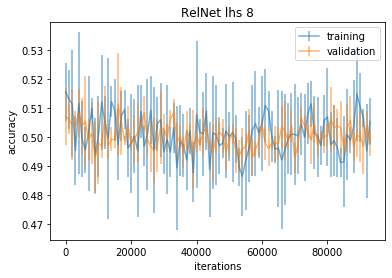

In [164]:
lhs = 8

dct['data_dir'] = join(root_path_data_dir, dataset_configurations[lhs])

lst_json = retrieve_id_repeated_experiments(slurm_id=None, path_model=path_model, args=dct)
lst_slurm_id_ = retrieve_id_repeated_experiments(lst_json[0].split('.')[0], path_model=path_model)

output_list_files = [join(path_, '%s.pt.json' % slurm_id) for slurm_id in lst_slurm_id_]

for json_ in output_list_files:
    
    model_json = json.load(open(json_, 'rb'))
    num_iters = model_json['args']['num_iterations']
    num_saved_loss_vals = len(model_json['train_losses'])
    record_every = model_json['args']['record_loss_every']
    if num_iters == record_every * num_saved_loss_vals:
        print('same') 
    else:
        print('stopped')
        print(json_)   
        print(num_saved_loss_vals * record_every)
    print('..........................................................')
    
x_tr_ls, tr_ls, x, acc_tr, acc_vl = retrieve_learning_performance(lst_slurm_id_, path_model)
plt.errorbar(x, np.mean(acc_tr, axis=0), np.std(acc_tr, axis=0), alpha=0.6, label='training')
plt.errorbar(x, np.mean(acc_vl, axis=0), np.std(acc_vl, axis=0), alpha=0.6, label='validation')
plt.title('RelNet lhs 8')
plt.xlabel('iterations', fontsize=10)
plt.ylabel('accuracy', fontsize=10);
plt.legend()

# Analyze activations for tree and chain NMNs with Residual Function

In [271]:
from vr.models.shnmn import _shnmn_func
from torch.autograd import Variable
import torch.nn.functional as F

Here we load the dataset

In [339]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

root_path = join(root_path_data_dir, dataset_configurations[1])
question_h5_path = join(root_path, 'val_questions.h5') 
feature_h5_path = join(root_path, 'val_features.h5') 
vocab_path = join(root_path, 'vocab.json')
vocab = vocab = load_vocab(vocab_path)

args_ = {'feature_h5': feature_h5_path,
         'question_h5': question_h5_path, 
         'vocab': vocab,
         'batch_size': 64}
clevr_load_ = ClevrDataLoader(**args_)

for i_, batch in enumerate(clevr_load_):
    (questions, _, feats, answers, programs, _) = batch
    questions_var = Variable(questions.to(device))
    feats_var = Variable(feats.to(device))
    break

Reading features from  /om/user/vanessad/om/user/vanessad/compositionality/sqoop-variety_1-repeats_30000/val_features.h5
Reading questions from  /om/user/vanessad/om/user/vanessad/compositionality/sqoop-variety_1-repeats_30000/val_questions.h5
Reading question data into memory


We load here the model

In [304]:
tree_model, tree_kwargs = load_execution_engine(join(path_model, lst_slurm_id_tree[1]+'.pt.best'))

if torch.cuda.is_available():
    tree_model.cuda()

using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.


In [311]:
id_sample = 0

In [340]:
[vocab['question_idx_to_token'][int(k_)] for k_ in questions[id_sample]]

['Y', 'left_of', 'H']

In [342]:
questions[id_sample]

tensor([31, 43, 14])

(3, 64, 64)


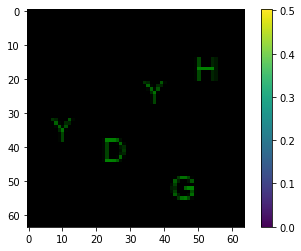

In [313]:
feats_ = feats[id_sample].detach().numpy()
print(feats_.shape)
plt.imshow(feats_.transpose(1,2,0))
plt.colorbar()

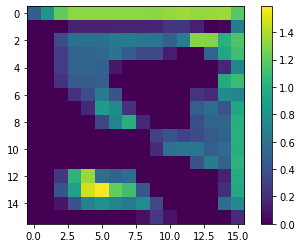

In [314]:
plt.imshow(tree_model.stem(feats_var)[id_sample, 2].cpu().detach().numpy())
plt.colorbar()

In [315]:
tree_model.question_embeddings(questions_var).shape

torch.Size([64, 3, 82112])

In [316]:
question_embed = tree_model.question_embeddings(questions_var)
stem_image = tree_model.stem(feats_var)

print(question_embed.shape, stem_image.shape)

res= _shnmn_func(question=question_embed, 
                img=stem_image.unsqueeze(1), 
                num_modules=tree_model.num_modules, 
                alpha=tree_model.alpha,
                tau_0=Variable(tree_model.tau_0),
                tau_1=Variable(tree_model.tau_1), 
                func=tree_model.func)

torch.Size([64, 3, 82112]) torch.Size([64, 64, 16, 16])


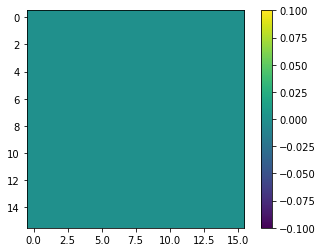

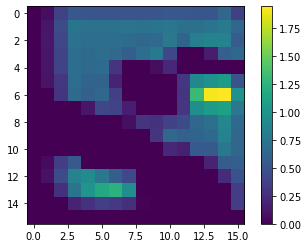

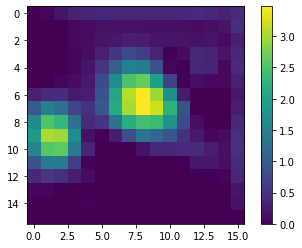

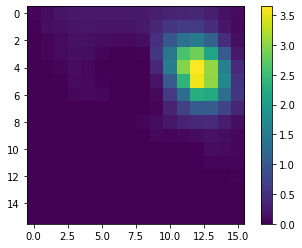

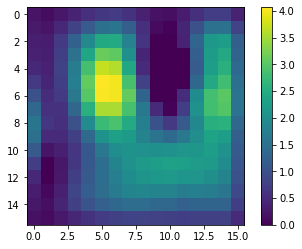

In [326]:
for h_ in res.cpu().detach().numpy()[id_sample]:
    plt.imshow(h_[0])
    plt.colorbar()
    plt.show()

In [353]:
left_of_idx = [i_ for i_, q_ in enumerate(questions) if q_[1]==43]

left_of_questions = questions[left_of_idx]
left_of_feats = feats[left_of_idx]

In [357]:
left_of_questions = Variable(left_of_questions.to(device))
left_of_feats = Variable(left_of_feats.to(device))

question_embed = tree_model.question_embeddings(left_of_questions)
stem_image = tree_model.stem(left_of_feats)

print(question_embed.shape, stem_image.shape)

res= _shnmn_func(question=question_embed, 
                img=stem_image.unsqueeze(1), 
                num_modules=tree_model.num_modules, 
                alpha=tree_model.alpha,
                tau_0=Variable(tree_model.tau_0),
                tau_1=Variable(tree_model.tau_1), 
                func=tree_model.func)

torch.Size([15, 3, 82112]) torch.Size([15, 64, 16, 16])


(3, 64, 64)


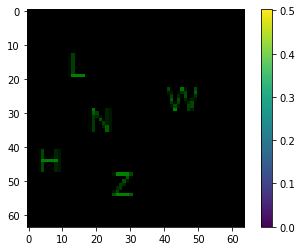

['Z', 'left_of', 'L']
(64, 16, 16)


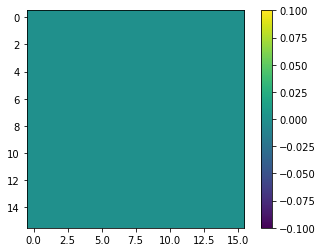

(64, 16, 16)


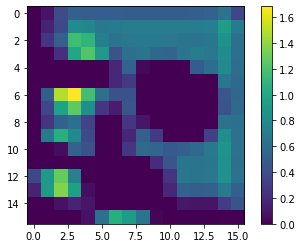

(64, 16, 16)


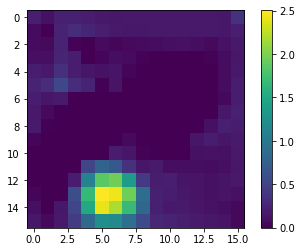

(64, 16, 16)


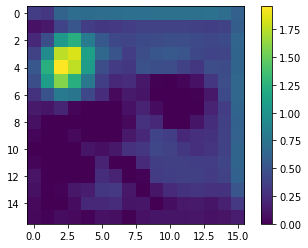

(64, 16, 16)


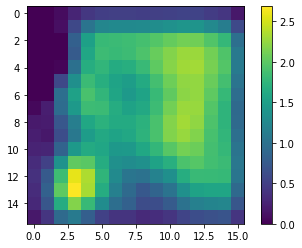

In [388]:
id_sample = 5

feats_ = feats[left_of_idx[id_sample]].detach().numpy()
print(feats_.shape)
plt.imshow(feats_.transpose(1,2,0))
plt.colorbar()
plt.show()

print([vocab['question_idx_to_token'][int(k_)] for k_ in left_of_questions[id_sample]])

for h_ in res.cpu().detach().numpy()[id_sample]:
    print(h_.shape)
    plt.imshow(h_[0])
    plt.colorbar()
    plt.show()